In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality
from networkx.algorithms import closeness_centrality
from networkx.algorithms import clustering

# Scraping IMDB list

Source: IMDB 500 Top-Rated Features Since 2000.
Scrapped data: data about the US movies

1. Movie – Name of the movie
2. Gross_worldwide	
3. Cast – list of all actors
4. Rank – position in ranking
5. Cast_number – number of actors played in the movie

In [ ]:
urls=('https://www.imdb.com/list/ls050871124/?sort=list_order,asc&st_dt=&mode=detail&page=1',
      'https://www.imdb.com/list/ls050871124/?sort=list_order,asc&st_dt=&mode=detail&page=2',
      'https://www.imdb.com/list/ls050871124/?sort=list_order,asc&st_dt=&mode=detail&page=3',
      'https://www.imdb.com/list/ls050871124/?sort=list_order,asc&st_dt=&mode=detail&page=4',
      'https://www.imdb.com/list/ls050871124/?sort=list_order,asc&st_dt=&mode=detail&page=5')

In [ ]:
def scrape_IMDB_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    cast_list=[]
    cast_names=[]
    gross_list=[]
    US_movies=[]
    movies_links=soup.findAll("h3",class_="lister-item-header")
    movies=[]
    k=0
    for a in movies_links:
        b=movies_links[k].find("a")
        c=b.get('href')
        url='https://www.imdb.com/'+c+'?ref_=ttls_li_tt'
        movies.append(url)
        k+=1
    x=0
    for url in movies:
        page_movie = requests.get(url)
        soup_movie = BeautifulSoup(page_movie.content, "html.parser")
        countries_soup=soup_movie.findAll("a",class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
        z=0
        for i in countries_soup:
            a=countries_soup[z].text
            z+=1
            if a =='United States':
                box_office=soup_movie.find("section",{"data-testid": "BoxOffice" })
                secs=box_office.findAll("span",class_="ipc-metadata-list-item__list-content-item")
                gross=secs[-1].text
                gross=gross.replace("$","")
                gross=gross.replace(",","")
                gross=int(gross)
                gross_list.append(gross)
                #searching links of cast
                cast=soup_movie.find("div",class_="ipc-title__wrapper").find("a").get("href")
                movie_name=soup_movie.find("h1").text
                US_movies.append(movie_name)
                cast_url='https://www.imdb.com'+cast
                cast_list.append(cast_url)
                #search for actors
                page_cast = requests.get(cast_url)
                soup_cast = BeautifulSoup(page_cast.content, "html.parser")
                actors_soup=soup_cast.findAll("img")
                i=0
                actors=[]
                for o in actors_soup:
                    i+=1
                    actor=o.get('title')
                    actors.append(actor)
                actors_new=[]
                for b in actors:
                    if b is not None and b !='list image':
                        actors_new.append(b)
                cast_names.append(actors_new)
            else:
                continue
    return cast_names,gross_list,US_movies

In [ ]:
Cast=[]
Gross=[]
Movies=[]
for url in urls:
    data=scrape_IMDB_page(url)
    Cast.extend(data[0])
    Gross.extend(data[1])
    Movies.extend(data[2])

In [ ]:
movies_data_500=pd.DataFrame({'Movie':Movies,'Gross_worldwide':Gross,'Cast':Cast })
movies_data_500['Rank']=np.arange(1,len(movies_data_500)+1,1)
lenght=[ len(i) for i in movies_data_500['Cast']]
movies_data_500['Cast_number']=lenght
movies_data_500.to_pickle("./IMDB_MTP.pkl")

In [ ]:
movies_data_500

# Exploring the dataset

## Count number of all and unique actors in the whole dataset

In [ ]:
movies_data_500=pd.read_pickle("./IMDB_MTP.pkl")

In [ ]:
All_actors=[]
for i in movies_data_500['Cast']:
    All_actors.extend(i)
print('All actors ' +str(len(All_actors)))

All actors 26228


In [ ]:
unique_actors=set(All_actors)
print('Unique actors ' +str(len(unique_actors)))

Unique actors 21434


## Reduce the number of actors to 10

In [ ]:
Reduced_list=[ i[:10] for i in movies_data_500['Cast']]

In [ ]:
movies_data_500_mod=movies_data_500.copy()
movies_data_500_mod=movies_data_500_mod.drop('Cast_number',axis=1)
movies_data_500_mod['Cast']=Reduced_list
movies_data_500_mod

,Movie,Gross_worldwide,Cast,Rank
0,The Social Network,224920375,"[Jesse Eisenberg, Rooney Mara, Bryan Barter, D...",1
1,The Artist,133432856,"[Jean Dujardin, Bérénice Bejo, John Goodman, J...",2
2,Toy Story 3,1066970811,"[Tom Hanks, Tim Allen, Joan Cusack, Ned Beatty...",3
3,The King's Speech,427374317,"[Colin Firth, Helena Bonham Carter, Derek Jaco...",4
4,Up,735099102,"[Ed Asner, Christopher Plummer, Jordan Nagai, ...",5
...,...,...,...,...
362,Freaky Friday,160846332,"[Jamie Lee Curtis, Lindsay Lohan, Mark Harmon,...",363
363,War of the Worlds,603873119,"[Tom Cruise, Dakota Fanning, Miranda Otto, Jus...",364
364,Miracle,64445708,"[Kurt Russell, Patricia Clarkson, Noah Emmeric...",365
365,Holes,71406573,"[Sigourney Weaver, Jon Voight, Tim Blake Nelso...",366


In [ ]:
All_actors_mod=[]
for i in movies_data_500_mod['Cast']:
    All_actors_mod.extend(i)
print('All actors modified ' +str(len(All_actors_mod)))
unique_actors_mod=set(All_actors_mod)
print('Unique actors ' +str(len(unique_actors_mod)))

All actors modified 3666
Unique actors 2718


# Preparing for networkX

## Create pairs of actors from each movie

In [ ]:
def actors_pair(actors_list):
    pairs=[]
    for pair in itertools.combinations(actors_list,2):
        pairs.append(pair) 
    return pairs  

In [ ]:
pairs=[]
i=0
for a in movies_data_500['Cast']:
    c=movies_data_500_mod.loc[i,'Cast']
    i+=1
    z=actors_pair(c)
    pairs.extend(z)   
print ('The number of all pairs is ' +str(len(pairs)))

The number of all pairs is 16480


Count the number of repetitions of pairs to understand how often who played with whom 

In [ ]:
my_dict={j:pairs.count(j) for j in pairs} 
pairss=my_dict.keys()
pairss=list(pairss)
valls=my_dict.values()
valls=list(valls)
network=pd.DataFrame({'Pair':pairss, 'Count':valls})

In [ ]:
print('The number of unique pairs is '+ str(len(my_dict)))

The number of unique pairs is 16331


## Inserting pairs into the networkx

In [ ]:
def edge_generator_weighted(nt):
    edges=[]
    i=0
    for pair in nt['Pair']:
        k=(pair[0],pair[1],network.loc[i,'Count'])
        i+=1
        edges.append(k)
    return edges

edges_weighted= edge_generator_weighted(network)

In [ ]:
G_w = nx.Graph()
G_w.add_nodes_from(unique_actors_mod)
G_w.add_weighted_edges_from (edges_weighted)

## Analyze weighted network
Are there disconnected components?

Plot the network for the whole dataset

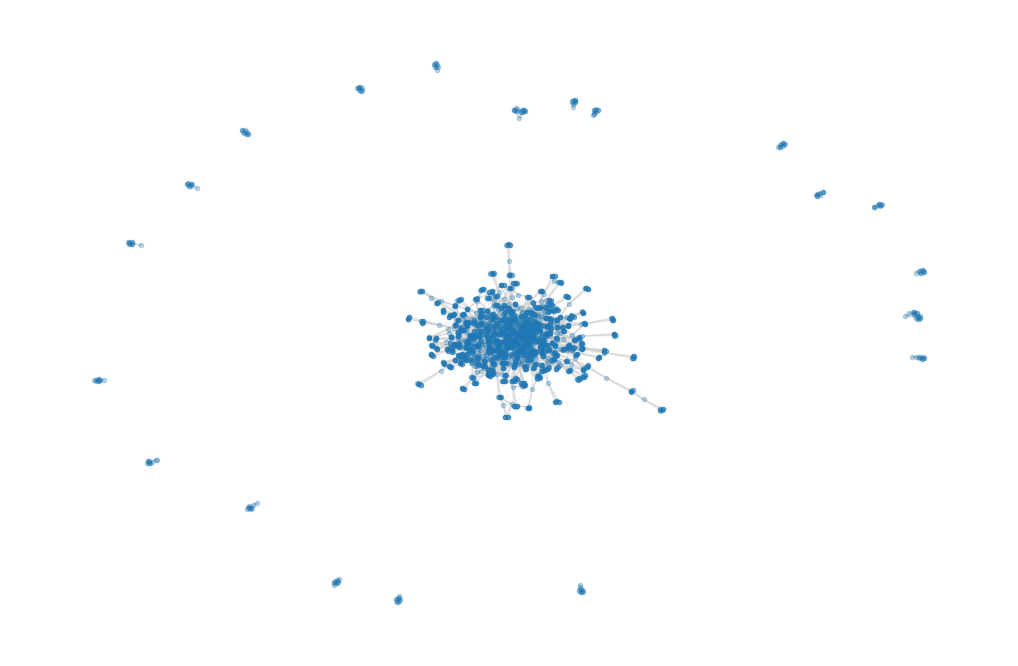

In [ ]:
plt.style.use('seaborn-pastel')
fig=plt.figure(figsize=(18,12))
fig.add_subplot(111)
nx.draw(G_w,node_size=20,alpha=0.3, style='-',edge_color='lightgrey')
plt.show()

# The analysis of the sub-network with 2503 connected nodes

>Blue color of the edge corrseponds to weight of 1

>Red color of the edge corresponds to weight between 2-3.

>Green color of the edge corresponds to weight greater than 3



In [ ]:
Gcc = G_w.subgraph(sorted(nx.connected_components(G_w), key=len, reverse=True)[0])

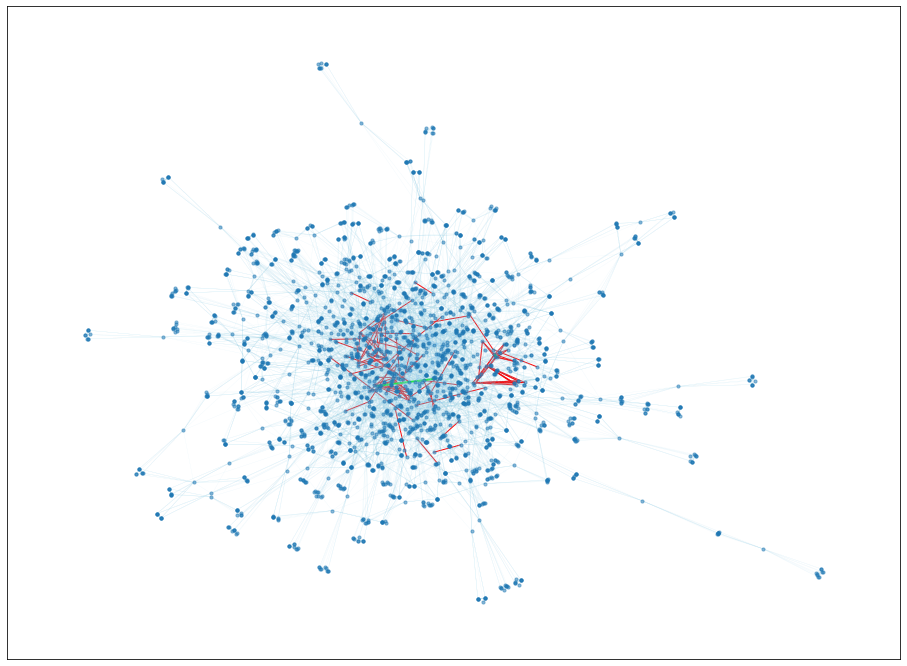

In [ ]:
fig=plt.figure(figsize=(16,12), facecolor='white')
fig.add_subplot(111)
elarge = [(u, v) for (u, v, d) in Gcc.edges(data=True) if (d["weight"] > 1)&(d["weight"] <= 3)]
etop = [(u, v) for (u, v, d) in Gcc.edges(data=True) if d["weight"] > 3]
esmall = [(u, v) for (u, v, d) in Gcc.edges(data=True) if d["weight"] <= 1]

pos = nx.spring_layout(Gcc, seed=7)

nx.draw_networkx_nodes(Gcc,pos, node_size=10,alpha=0.5)
nx.draw_networkx_edges(Gcc, pos, edgelist=elarge,width=1,edge_color='red')
nx.draw_networkx_edges(Gcc, pos, edgelist=etop,width=2,edge_color='lime') 
nx.draw_networkx_edges(Gcc, pos, edgelist=esmall,width=.2,alpha=0.2, edge_color='skyblue')
plt.show()

Display the 'periphery' nodes, nodes with eccentricity equal to the diameter

How could Tom Hardy get to Lindsay Lohan?

In [ ]:
P = nx.shortest_path (Gcc, source ="Tom Hardy", target ="Lindsay Lohan")
print (P)

['Tom Hardy', 'Joseph Gordon-Levitt', 'Tommy Lee Jones', 'Lindsay Lohan']


## Degree distribution for the connected network
k=9 has the highest frequency because we specified that each movie actor set equals 10.

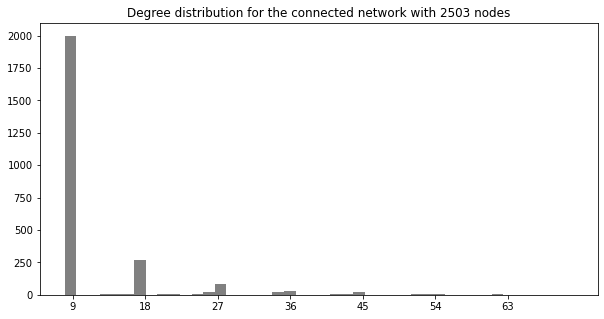

In [ ]:
degree_list = sorted([d for n, d in Gcc.degree()], reverse=True)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
ax.hist(degree_list,bins=len(set(degree_list)),color='grey')
ax.set_xticks(np.arange(9,np.max(degree_list),9))
#ax.hist([len(i) for i in m.iloc[:,1]],np.arange(10) - 0.5,color='grey')
ax.set_title('Degree distribution for the connected network with 2503 nodes')
plt.show()

## Create a modified connected network for nodes with degree not divisable by 9

In [ ]:
node_degree_dict=nx.degree(G_w)
G_modified=nx.subgraph(G_w,[x for x in G_w.nodes() if node_degree_dict[x]%9!=0])
G_modified_connected = G_modified.subgraph(sorted(nx.connected_components(G_modified), key=len, reverse=True)[0])
node_degree_dict_mod=nx.degree(G_modified_connected)
top_cast=[x for x in G_modified_connected.nodes() if node_degree_dict_mod[x]>11]
labels = {}    
for node in G_modified_connected.nodes():
    if node in top_cast:
        #set the node name as the key and the label as its value 
        labels[node] = node

In [ ]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig=plt.figure(figsize=(16,12), facecolor='white')
fig.add_subplot(111)
Nodes=G_modified_connected.nodes()
clustering = nx.clustering(G_modified_connected)
nodes_colors = np.asarray([clustering[n] for n in Nodes])
pos = nx.layout.spring_layout(G_modified_connected)
nodes = nx.draw_networkx_nodes(G_modified_connected, pos, node_color=nodes_colors,
                               cmap=plt.cm.rainbow,node_size=100)
edges = nx.draw_networkx_edges(G_modified_connected,pos,width=0.5)
cmap=plt.cm.rainbow
vmin = min(nodes_colors)
vmax = max(nodes_colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm.set_array(nodes_colors)
plt.colorbar(sm,label='Clustering coefficient of the nodes')
plt.show()

In [ ]:
coreness = nx.algorithms.centrality.closeness_centrality(Gcc)
Gcc_coreness = sorted([d for d in coreness.values()], reverse=True)


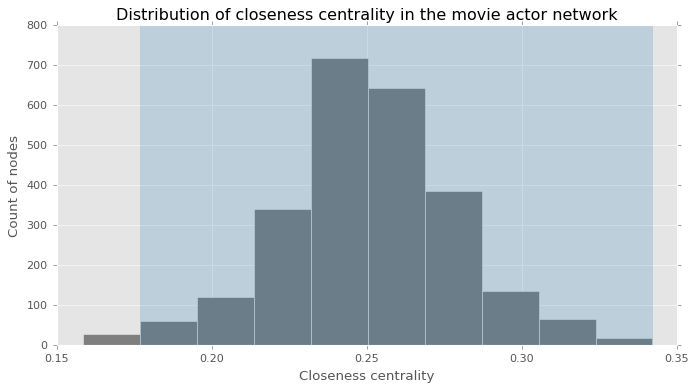

In [ ]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)

ax.hist(Gcc_coreness, color='tab:gray')
ax.axvspan (0.177,0.342, 0,1400, color='tab:blue', alpha=0.2)
ax.set_ylabel('Count of nodes')
ax.set_xlabel('Closeness centrality')
plt.title('Distribution of closeness centrality in the movie actor network')
plt.savefig('cc.jpg')

In [ ]:
periphery_nodes=nx.periphery(Gcc)
print(periphery_nodes)

['Jamie Tirelli', 'Ray Santiago', 'Sihung Lung', 'Ziyi Zhang', 'Louis Guss', 'Paul Calderon', 'Elisa Bocanegra', 'Yan Hai', 'Herb Lovelle', 'Fazeng Li', 'Deming Wang', 'Xian Gao', 'Michelle Yeoh', 'Douglas Santiago', 'Víctor Sierra', 'Pei-Pei Cheng', 'Chow Yun-Fat', 'Shannon Walker Williams']


In [ ]:
len(periphery_nodes)

18

## Network attributes

In [ ]:
print('the size of the network is: ' + str(nx.diameter(Gcc)))
print('the average path length for the network is: ' + str(round(nx.average_shortest_path_length(Gcc))))

the size of the network is: 9
the average path length for the network is: 4


In [ ]:
print('the average degree of connectivity is: ' + str((nx.algorithms.connectivity.connectivity.node_connectivity(Gcc))))


the average degree of connectivity is: 1


In [ ]:
number_nodes = nx.Graph.number_of_nodes(Gcc)
number_edges = nx.Graph.number_of_edges(Gcc)
print('the average degree of connectivity is:' + str(number_nodes/number_edges))

the average degree of connectivity is:0.1632639749527102


## Node measures - Centrality and Clustering

In [ ]:

# degree centrality
dc = degree_centrality(Gcc)

# eigenvector_centrality
ec = eigenvector_centrality(Gcc)

# betweeness centrality
bc = betweenness_centrality(Gcc)

#closeness centrality
cc = coreness

#clustering coefficient
clco= clustering(Gcc)
# visualize the results
df = pd.DataFrame({'degree_centrality': dc,
                   'betweenness_centrality': bc,
                   'eigenvector_centrality': ec,
                   'closeness_centrality': cc,
                   'clustering_coefficent': clco})
df.head()

,degree_centrality,betweenness_centrality,eigenvector_centrality,closeness_centrality,clustering_coefficent
Lily McCann,0.003597,0.000000,0.007852,0.247209,1.000000
Elizabeth Berrington,0.003597,0.000000,0.007959,0.245776,1.000000
Maximiliano Hernández,0.003597,0.000000,0.005808,0.234841,1.000000
Sean Astin,0.006795,0.000089,0.008515,0.242371,0.654412
Angela Bassett,0.003597,0.000000,0.003626,0.233635,1.000000


### Descriptive statistics for node measures




In [ ]:
df.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,closeness_centrality,clustering_coefficent
count,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000
mean,0.004896,0.001216,0.013140,0.250757,0.877181
std,0.003212,0.003720,0.015065,0.028033,0.250525
min,0.003197,0.000000,0.000039,0.158666,0.117505
25%,0.003597,0.000000,0.004321,0.234445,1.000000
50%,0.003597,0.000000,0.008259,0.250100,1.000000
75%,0.003597,0.000000,0.016794,0.267909,1.000000
max,0.028377,0.039297,0.144938,0.342224,1.000000


### Detecting cliques in the network from the clustering coefficent of the nodes

We notice from the descriptive statistics table that there are many nodes with a high clustering coefficient (1). This indicates that we have many cliques in the network. 

In [ ]:
Top_cc = df.sort_values(by=['clustering_coefficent'], ascending=False)

In [ ]:
Top_cc = Top_cc['clustering_coefficent']

In [ ]:
cliques = []

for key,value in Top_cc.items():
    if value == 1:
        cliques.append(key)

In [ ]:
print('There are ' + str(len(cliques)) + ' nodes in cliques in this network.')

There are 1997 nodes in cliques in this network.


### Determining the most important actors in the network using centrality measures

Actors with highest degree centrality

In [ ]:
Top_dc = df.sort_values(by=['degree_centrality'], ascending=False).head(5)
Top_dc = Top_dc['degree_centrality']
Top_dc

John C. Reilly            0.028377
Joseph Gordon-Levitt      0.026779
Laura Linney              0.025180
Philip Seymour Hoffman    0.024780
Jim Broadbent             0.024780
Name: degree_centrality, dtype: float64

Actors with highest betweenness centrality

In [ ]:
Top_bc = df.sort_values(by=['betweenness_centrality'], ascending=False).head(5)
Top_bc = Top_bc['betweenness_centrality']

In [ ]:
Top_bc

Joseph Gordon-Levitt      0.039297
John C. Reilly            0.036722
Laura Linney              0.030790
Philip Seymour Hoffman    0.030388
Tommy Lee Jones           0.030081
Name: betweenness_centrality, dtype: float64

Actors with highest Eigenvector Centrality

In [ ]:
Top_ec = df.sort_values(by=['eigenvector_centrality'], ascending=False).head(5)
Top_ec = Top_ec['eigenvector_centrality']

In [ ]:
Top_ec

Joseph Gordon-Levitt      0.144938
Philip Seymour Hoffman    0.115716
John C. Reilly            0.110678
Christian Bale            0.110261
Leonardo DiCaprio         0.100282
Name: eigenvector_centrality, dtype: float64

### Run the Kojaku-Masuda algorithm for the network to detect communities

In [ ]:
algorithm.detect(G_w)
c = algorithm.get_pair_id()
groups_sizes=Counter(list(c.values()))

In [ ]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
ax.hist(groups_sizes.values(),color='grey')
ax.set_ylabel('Count of groups with k size')
ax.set_xlabel('Size of the community')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [ ]:
print('The number of communities detected by Kojaku-Masuda algorithm is '+ str(len(groups_index)))

# The interactive visualization of a component of the network using Bokeh library

In [7]:
import os
import pickle
os.chdir('//Users/tianahawasly/Desktop/')
open_file = open("G_modified_connected.pkl", "rb")
G_modified_connected = pickle.load(open_file)
open_file.close()

In [8]:
import cpnet
from collections import namedtuple
from math import sqrt
import bokeh
from bokeh.models import HoverTool
from bokeh.plotting import show, figure
from bokeh.colors import RGB
import random

def create_bokeh_graph(graph):
    
    def gen_edge_coordinates(graph, layout):
        xs = []
        ys = []
        val = namedtuple("edges", "xs ys")
        for edge in graph.edges():
            from_node = layout[edge[0]]
            to_node = layout[edge[1]]
            xs.append([from_node[0],to_node[0]])
            ys.append([from_node[1], to_node[1]])
        return val(xs=xs, ys=ys)

    def gen_node_coordinates(layout):
        names, coords = zip(*layout.items())
        xs, ys = zip(*coords)
        val = namedtuple("nodes", "names xs ys")
        return val(names=names, xs=xs, ys=ys)
    
    #Calc Layout - Slowest Part
    plot_layout = nx.spring_layout(graph,
                                k=1/(sqrt(graph.number_of_nodes() * 0.75)),
                                iterations=60,
                                scale = 2)
    
    _nodes = gen_node_coordinates(plot_layout)
    _edges = gen_edge_coordinates(graph, plot_layout)
    
    #Prepare Bokeh-Figure
    hover = HoverTool(tooltips=[('name', '@name'), 
                                ('node_id', '$index'),
                                ('degree', '@degree'),
                                ('katz_centrality', '@katz_centrality'),
                                ('clustering', '@clustering'),
                                ('cluster_nr', '@community_nr')], names=["show_hover"])

    fig = figure(width=800, height=600, 
                 tools=[hover, 'box_zoom', 'reset', 'wheel_zoom', 'pan'])
    fig.toolbar.logo = None
    fig.axis.visible = False                            
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    
    #Draw Edges
    source_edges = bokeh.models.ColumnDataSource(dict(xs=_edges.xs, ys=_edges.ys))
    fig.multi_line('xs', 'ys', line_color='navy', source=source_edges, alpha=0.17)
    
    #Calc numbers
    degrees = list(dict(nx.degree(graph)).values())
    clustering = list(dict(nx.clustering(graph)).values())
    algorithm = cpnet.KM_config()
    algorithm.detect(graph)
    communs = algorithm.get_pair_id()
    nodes, communities = zip(*communs.items())
    katz = list(nx.katz_centrality(graph).values())
    
    #create Colormaps
    colormap_coms = {x : RGB(random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)) 
                     for x in list(set(communities))}
    community_color_list, community_nr = zip(*[(colormap_coms[communs[node]], communs[node]) for node in nodes])

    
    graph_nodes = graph.number_of_nodes()
    
    colors = ['firebrick' for node in range(graph_nodes)]
    
    #Draw circles
    source_nodes = bokeh.models.ColumnDataSource(dict(xs=_nodes.xs, ys=_nodes.ys, name=_nodes.names, 
                                                      single_color = colors,
                                                      color_by_community = community_color_list, 
                                                      degree=degrees, 
                                                      clustering=clustering, community_nr=community_nr,
                                                      katz_centrality = katz))
    
    r_circles = fig.circle('xs', 'ys', fill_color='color_by_community', line_color='single_color', 
                           source = source_nodes, alpha=0.8, size=9, name="show_hover")
    
    

    
    button = bokeh.models.widgets.Select(title="Color", value="single_color", 
                                         options=["single_color", "color_by_community"])
    
    
    
    #Create grid and save
    layout_plot = bokeh.layouts.gridplot([[fig]])
    
    #if file is wanted
    #bokeh.io.output_file(f"graph.html")
    #bokeh.io.save(layout_plot)
    
    show(layout_plot)


In [12]:
create_bokeh_graph(G_modified_connected)